# Modelling

## Contents:
 
 * Introduction
 
 * Sourcing and Loading
   * Importing relevant libraries
 
 * Dataset
   * Preparing the datasets

 * Features Importance Using Deep & Cross Network (DCN-V2)
   * Deep and cross network (DCN) came out of Google Research, and is designed to learn explicit and bounded-degree cross features effectively
   * Feature Cross
   * Cross Network
   * Deep & Cross Network
   * Model Structure
   * Model construction
   * Model Training
   * DCN (stacked)
   * Low-rank DCN
   * DNN (Cross Layer = False)
   
   
 * The Two-Tower and Ranking Models
   * Case 1: Baseline
       * A Multi-Task Model
           * Rating-specialized model
		   * Retrieval-specialized model
		   * Joint model: Baseline
            * Summary of the Baseline Joint Model
           
   * Case 2: Tuned Joint Model
        * Implementing a Retrieval Model
		* A Multi-Task Model
		* Joint model
        
 * Summary of all models' metrics

### Introduction

For this final notebook, we will be dealing with:

- The Feature importance using Deep and Cross Network (DCN-v2)

- Training multiple TensorFlow Recommenders.

- Applying hyperparameters tuning where applicable to ensure every algorithm will result in the best prediction possible.

- Finally, evaluating these Models.

### Sourcing and Loading
**Importing relevant libraries**

In [1]:
# Import the necessary Libararies: 

import os
import pprint
import tempfile
import matplotlib.pyplot as plt
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Dict, Text
import pandas as pd
import numpy as np

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import seaborn as sns
import matplotlib.pyplot as plt

import re

import warnings
warnings.filterwarnings("ignore")


plt.style.use('ggplot')

## Dataset: 

**Movie Lens** contains a set of movie ratings from the MovieLens website, a movie recommendation service. This dataset was collected and maintained by [GroupLens](https://grouplens.org/) , a research group at the University of Minnesota. There are 5 versions that include: "25m", "latest-small", "100k", "1m", "20m". In all of the datasets, the movies and ratings data are joined on "movieId". The 25m dataset, latest-small dataset, and 20m dataset contain only the movie and rating data. The 1m dataset and 100k dataset contain demographic data in addition to the movie and rating data.


**[movie_lens/100k-ratings](https://www.tensorflow.org/datasets/catalog/movie_lens#movie_lens100k-ratings):**
 * Config description: This dataset contains 100,000 anonymous ratings of approximately 1,682 movies made by 943 MovieLens users who joined MovieLens. Ratings are in whole-star increments. This dataset contains demographic data of users in addition to data on movies and ratings.
 
 * This dataset is the second largest dataset that includes demographic data from movie_lens.
 * "user_gender": gender of the user who made the rating; a true value corresponds to male.
 * "bucketized_user_age": bucketized age values of the user who made the rating, the values and the corresponding ranges are:
   * 1: "Under 18"
   * 18: "18-24"
   * 25: "25-34"
   * 35: "35-44"
   * 45: "45-49"
   * 50: "50-55"
   * 56: "56+"
 * "movie_genres": The Genres of the movies are classified into 21 different classes as below:
   * 0: Action
   * 1: Adventure
   * 2: Animation
   * 3: Children
   * 4: Comedy
   * 5: Crime
   * 6: Documentary
   * 7: Drama
   * 8: Fantasy
   * 9: Film-Noir
   * 10: Horror
   * 11: IMAX
   * 12: Musical
   * 13: Mystery
   * 14: Romance
   * 15: Sci-Fi
   * 16: Thriller
   * 17: Unknown
   * 18: War
   * 19: Western
   * 20: no genres listed
   
 * "user_occupation_label": the occupation of the user who made the rating represented by an integer-encoded label; labels are preprocessed to be consistent across different versions
 * "user_occupation_text": the occupation of the user who made the rating in the original string; different versions can have different set of raw text labels
 * "user_zip_code": the zip code of the user who made the rating.
 * Download size: 4.70 MiB
 * Dataset size: 32.41 MiB
 * Auto-cached ([documentation](https://www.tensorflow.org/datasets/performances#auto-caching)): No
 * Features:
 ```
 FeaturesDict({
               'bucketized_user_age': tf.float32,
               'movie_genres': Sequence(ClassLabel(shape=(), dtype=tf.int64, num_classes=21)),
               'movie_id': tf.string,
               'movie_title': tf.string,
               'raw_user_age': tf.float32,
               'timestamp': tf.int64,
               'user_gender': tf.bool,
               'user_id': tf.string,
               'user_occupation_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=22),
               'user_occupation_text': tf.string,
               'user_rating': tf.float32,
               'user_zip_code': tf.string,
              })
 ```
**Example:**

|bucketized_user_age	|movie_genres|	movie_id|	movie_title|	raw_user_age|	timestamp|	user_gender|	user_id	|user_occupation_label|	user_occupation_text	|user_rating	|user_zip_code|
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
|45.0	|7 (Drama)|b'357'	|b"One Flew Over the Cuckoo's Nest (1975)"	|46.0	|879024327	|True	|b'138'	|4 (doctor/health care)	|b'doctor'	|4.0|	b'53211'|


### Preparing the datasets

Let's have a first look at the data.

We use the MovieLens dataset from Tensorflow Datasets. Loading **[movie_lens/100k-ratings](https://www.tensorflow.org/datasets/catalog/movie_lens#movie_lens100k-ratings)** yields a ***tf.data.Dataset*** object containing the ratings data and loading **[movie_lens/100k-movies](https://www.tensorflow.org/datasets/catalog/movie_lens#movie_lens100k-movies)** yields a ***tf.data.Dataset*** object containing only the movies data.

Note that since the MovieLens dataset does not have predefined splits, all data are under train split.

### Features Importance Using Deep & Cross Network (DCN-V2)

**Deep and cross network (DCN) came out of Google Research, and is designed to learn explicit and bounded-degree cross features effectively**

- Large and sparse feature space is extremely hard to train.
- Oftentimes, we needed to do a lot of manual feature engineering, including designing cross features, which is very challenging and less effective.
- Whilst possible to use additional neural networks under such circumstances, it's not the most efficient approach. DCN is specifically designed to tackle all of the above challenges.

**Feature Cross**

Let's say we're building a recommender system to sell a blender to customers. Then our customers' past purchase history, such as purchased apples and purchased recipes books, or geographic features are single features. If one has purchased both apples and recipes books, then this customer will be more likely to click on the recommended blender. The combination of purchased apples and the purchased recipes books is referred to as feature cross, which provides additional interaction information beyond the individual features.

**Cross Network**

In real world recommendation systems, we often have large and sparse feature space. So, identifying effective feature processes in this setting would often require manual feature engineering or exhaustive search, which is highly inefficient. To tackle this issue, Google Research team has proposed DCN. It starts with an input layer, typically an embedded layer, followed by a cross network containing multiple cross layers that models explicitly feature interactions, and then combines with a deep network that models implicit feature interactions. The deep network is just a traditional multilayer construction. But the core of DCN is really the cross network. It explicitly applies feature crossing at each layer. And the highest polynomial degree increases with layer depth.

**Deep & Cross Network**

There are a couple of ways to combine the cross network and the deep network:

- Stack the deep network on top of the cross network.
- Place deep & cross networks in parallel.

**Model Structure**

We first train a DCN model with a stacked structure, that is, the inputs are fed to a cross network followed by a deep network.

In [87]:
os.chdir("C:\\Users\\mohamed.ziane\\tensorflow_datasets\\Notebooks")

In [88]:
# Now, let's look at the final dataframe where we merged the tensorflow dataset with movies_metadata.csv and credits.csv**

ratings = pd.read_csv('ratings.csv', encoding='ISO-8859-1')

In [89]:
# now let's look at the the table:

ratings.head()
ratings.info()

,bucketized_user_age,movie_genres,movie_id,movie_title,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code,director,release_date,star
0,45,[7],357,One Flew Over the Cuckoo's Nest,879024327,True,138,4,doctor,4,53211,Milos Forman,185500800,Jack Nicholson
1,25,"[4, 14]",709,Strictly Ballroom,875654590,True,92,5,entertainment,2,80525,Baz Luhrmann,714268800,Paul Mercurio
2,50,"[5, 7]",56,Pulp Fiction,883326919,True,60,4,healthcare,4,6472,Quentin Tarantino,779155200,John Travolta
3,50,"[10, 16]",895,Scream 2,891409199,True,197,18,technician,3,75094,Wes Craven,881625600,David Arquette
4,18,"[7, 16]",325,Crash,876346551,False,601,1,artist,4,99687,David Cronenberg,837561600,James Spader


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88649 entries, 0 to 88648
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   bucketized_user_age    88649 non-null  int64 
 1   movie_genres           88649 non-null  object
 2   movie_id               88649 non-null  int64 
 3   movie_title            88649 non-null  object
 4   timestamp              88649 non-null  int64 
 5   user_gender            88649 non-null  bool  
 6   user_id                88649 non-null  int64 
 7   user_occupation_label  88649 non-null  int64 
 8   user_occupation_text   88649 non-null  object
 9   user_rating            88649 non-null  int64 
 10  user_zip_code          88649 non-null  int64 
 11  director               88649 non-null  object
 12  release_date           88649 non-null  int64 
 13  star                   88649 non-null  object
dtypes: bool(1), int64(8), object(5)
memory usage: 8.9+ MB


In [90]:
# movie_id from int to str:
ratings['movie_id'] = ratings['movie_id'].astype('str')

# user_id from int to str:
ratings['user_id'] = ratings['user_id'].astype('str')

# user_zip_code from int to str:
ratings['user_zip_code'] = ratings['user_zip_code'].astype('str')

#let's have a general view:
ratings_missing = pd.concat([ratings.nunique(), ratings.dtypes, ratings.isnull().sum(), 100*ratings.isnull().mean()], axis=1)
ratings_missing.columns = [['count', 'data_type', 'missing_count', 'missing%']]
ratings_missing

,count,data_type,missing_count,missing%
bucketized_user_age,7,int64,0,0.0
movie_genres,179,object,0,0.0
movie_id,1117,object,0,0.0
movie_title,1099,object,0,0.0
timestamp,40530,int64,0,0.0
user_gender,2,bool,0,0.0
user_id,925,object,0,0.0
user_occupation_label,17,int64,0,0.0
user_occupation_text,21,object,0,0.0
user_rating,5,int64,0,0.0


In [91]:
#let's wrap the **pandas dataframe** into **tf.data.Dataset** object using **tf.data.Dataset.from_tensor_slices** using: tf.data.Dataset.from_tensor_slices
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings))

In [92]:
#The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:
#View the data from ratings dataset:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)
    
type(ratings)

{'bucketized_user_age': 45,
 'director': b'Milos Forman',
 'movie_genres': b'[7]',
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest",
 'release_date': 185500800,
 'star': b'Jack Nicholson',
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4,
 'user_zip_code': b'53211'}


tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

**Next, we're only going to extract the movie title and the user id.**

- We are actually not going to extract the rating itself and the reason why is that we're treating these as implicit recommendations.
- We are going to assume that any movie that a user rated is one that they were really interested in if they took the time to watch it and it therefore expresses some level of interest.

*That being said, any rating is an implicit positive rating for a movie and the absence of a rating is an implicit negative rating for that movie.*

In [93]:
#Let's select the necessary attributes:

ratings = ratings.map(lambda x: {
                                 "movie_id": x["movie_id"],
                                 "user_id": x["user_id"],
                                 "user_rating": x["user_rating"],
                                 "user_gender": int(x["user_gender"]),
                                 "user_zip_code": x["user_zip_code"],
                                 "user_occupation_text": x["user_occupation_text"],
                                 "director": x["director"],
                                 "star": x["star"],
                                 "movie_genres": x["movie_genres"],    
                                 "bucketized_user_age": int(x["bucketized_user_age"]),                                
                                })

len(ratings)

88649

In [95]:
#Let's select the necessary attributes:

ratings = ratings.map(lambda x: {
                                 "movie_id": x["movie_id"],
                                 "user_id": x["user_id"],
                                 "user_rating": x["user_rating"],
                                 "user_gender": int(x["user_gender"]),
                                 "user_zip_code": x["user_zip_code"],
                                 "user_occupation_text": x["user_occupation_text"],
                                 "director": x["director"],
                                 "star": x["star"],
                                 "movie_genres": x["movie_genres"],    
                                 "bucketized_user_age": int(x["bucketized_user_age"]),                                
                                })

len(ratings)

88649

In [96]:
# let's use a random split, putting 75% of the ratings in the train set, and 25% in the test set:
# Assign a seed=42 for consistency of results and reproducibility:
seed = 42
l = len(ratings)

tf.random.set_seed(seed)
shuffled = ratings.shuffle(l, seed=seed, reshuffle_each_iteration=False)

#Save 75% of the data for training and 25% for testing:
train_ = int(0.75 * l)
test_ = int(0.25 * l)

train = shuffled.take(train_)
test = shuffled.skip(train_).take(test_)

In [97]:
#Then, let's create a vocabulary for each feature:

feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age", "director", "star"]

vocabularies = {}

for feature_name in feature_names:
    vocab = ratings.batch(l).map(lambda x: x[feature_name])
    vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

### Model construction
- The model architecture we will be building starts with an embedded layer, which is fed into a cross network followed by a deep network. 
- The embedded dimension is set to 32 for all the features. 
- Please note that we could also have used different embedded sizes for different features.

In [98]:
class DCN(tfrs.Model):
    def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
        super().__init__()

        self.embedding_dimension = 32

        str_features = ["movie_id", "user_id", "user_zip_code", 
                        "user_occupation_text", "director", "star"]
        int_features = ["user_gender", "bucketized_user_age"]

        self._all_features = str_features + int_features
        self._embeddings = {}

        # Compute embeddings for string features. experimental.preprocessing
        # WARNING:tensorflow:mask_value is deprecated, use mask_token instead.
        for feature_name in str_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                                                                [tf.keras.layers.experimental.preprocessing.StringLookup(
                                                                 vocabulary=vocabulary, mask_token=None),
                                                                 tf.keras.layers.Embedding(len(vocabulary) + 1,
                                                                 self.embedding_dimension)
                                           ])
      
        # Compute embeddings for int features.
        for feature_name in int_features:
            vocabulary = vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                                                                 [tf.keras.layers.experimental.preprocessing.IntegerLookup(
                                                                 vocabulary=vocabulary, mask_token=None), 
                                                                 tf.keras.layers.Embedding(len(vocabulary) + 1,
                                                                 self.embedding_dimension)
                                           ])

        if use_cross_layer:
            self._cross_layer = tfrs.layers.dcn.Cross(
                                                      projection_dim=projection_dim,
                                                      kernel_initializer="glorot_uniform")
        else:
            self._cross_layer = None

        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layer_sizes]

        self._logit_layer = tf.keras.layers.Dense(1)

        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
            )

    def call(self, features):
        # Concatenate embeddings
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))

        x = tf.concat(embeddings, axis=1)

        # Build Cross Network
        if self._cross_layer is not None:
            x = self._cross_layer(x)
    
    # Build Deep Network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)

        return self._logit_layer(x)

    def compute_loss(self, features, training=False):
        labels = features.pop("user_rating")
        scores = self(features)
        return self.task(labels=labels,predictions=scores,
        )        

### Model Training

In [99]:
# Shuffling, batching, and caching the training and evaluatiing the data:
# Segmenting the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch, 
# while having a batch size which is a multiple of 2^n.

cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

In [100]:
# Now let's define a function that runs a model multiple times and returns the model's RMSE mean and standard deviation out of multiple runs

def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
    models = []
    rmses = []

    for i in range(num_runs):
        model = DCN(use_cross_layer=use_cross_layer,
                    deep_layer_sizes=deep_layer_sizes,
                    projection_dim=projection_dim)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
        models.append(model)

        model.fit(cached_train, epochs=epochs, verbose=False)
        metrics = model.evaluate(cached_test, return_dict=True)
        rmses.append(metrics["RMSE"])

    mean, stdv = np.average(rmses), np.std(rmses)

    return {"model": models, "mean": mean, "stdv": stdv}

We set some hyper-parameters for the models. 

- Note that these hyper-parameters are set globally for all the models for demonstration purpose. 

- If you want to obtain the best performance for each model, or to conduct a fair comparison amongst models, I would suggest you to fine-tune the hyper-parameters. 

- Remember that the model architecture and optimization schemes are intertwined.

In [101]:
epochs = 32
learning_rate = 0.01

### DCN (stacked)

In [102]:
#We first train a DCN model with a stacked structure, that is, the inputs are fed to a cross network followed by a deep network.

dcn_result = run_models(use_cross_layer=True, deep_layer_sizes=[192, 192])

11/11 [==============================] - 0s 8ms/step - RMSE: 0.9872 - loss: 0.9718 - regularization_loss: 0.0000e+00 - total_loss: 0.9718


<Figure size 864x864 with 0 Axes>

Visualizing the Weight Matrix Learned by DCN


<Figure size 864x864 with 0 Axes>

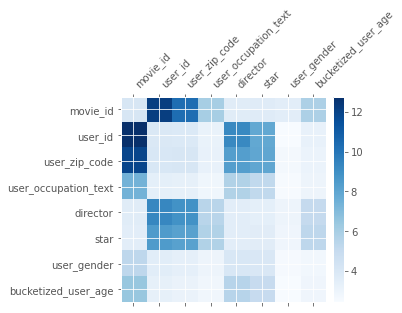

In [103]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])
dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
    for j in range(len(features)):
        block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
        block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(12,12))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)
#plt.title('Visualizing the Weight Matrix Learned by DCN')
print('Visualizing the Weight Matrix Learned by DCN')

From the above graph, we can visualize the weights from the cross network and see if it has successfully learned the important feature process. 

As shown above, fro instance, the feature cross of user ID and movie ID are of great importance.

### Low-rank DCN

To reduce the training and running cost, we leverage low-rank techniques to approximate the DCN weight matrices. 

- The rank is passed in through the projection_dim argument: a smaller projection_dim results in a lower cost. 

- Note that projection_dim needs to be smaller than the (input size)/2 to reduce the cost. In practice, we've observed that using a low-rank DCN with a rank of (input size)/4 consistently preserved the accuracy of a full-rank DCN.

In [104]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

11/11 [==============================] - 0s 7ms/step - RMSE: 0.9496 - loss: 0.9042 - regularization_loss: 0.0000e+00 - total_loss: 0.9042


### DNN (Cross Layer = False)

In [105]:
# We train a same-sized DNN model as a reference.
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

11/11 [==============================] - 0s 7ms/step - RMSE: 0.9479 - loss: 0.8995 - regularization_loss: 0.0000e+00 - total_loss: 0.8995


In [106]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(dnn_result["mean"], dnn_result["stdv"]))

DCN            RMSE mean: 0.9811, stdv: 0.0241
DCN (low-rank) RMSE mean: 0.9666, stdv: 0.0128
DNN            RMSE mean: 0.9531, stdv: 0.0115


### Multi-Task Model - Joint Model

### The Two-Tower and Ranking Models

**Real-world recommender systems are often composed of two stages:**

- *The retrieval stage* (Selects recommendation candidates): is responsible for selecting an initial set of hundreds of candidates from all possible candidates. 
    - The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.

- *The ranking stage* (Selects the best candidates and rank them): takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. 
    - Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.

**Retrieval models are often composed of two sub-models:**

The retrieval model embeds user ID's and movie ID's of rated movies into embedded layers of the same dimension:

- A query model computing the query representation (normally a fixed-dimensionality embedding vector) using query features.

- A candidate model computing the candidate representation (an equally-sized vector) using the candidate features.

- As shown below, the two models are multiplied to create a query-candidate affinity scores for each rating during training. If the affinity score for the rating is higher than  other candidates, then we can consider the model to be reasonable.

**Embedded layer Magic**

As discussed above, we might think of the embedded layers as just a way of encoding a way of forcing the categorical data into some sort of a standard format that can be easily fed into a neural network and usually that's how it's used but embedded layers are more than that! 

The way they're working under the hood is every unique id is being mapped to a vector of n dimensions, but it's going to be like a vector of 32 floating point values and we can think of this as a position in a 32-dimensional space that represents the similarity between one user id and another or between one movie id and another so by using embeddied layers in this way we're getting around that whole problem of data sparsity and sparse vectors and at the same time, we're getting a measure of similarity  so it's a very simple way of getting recommendation candidates.

The outputs of the two models are then multiplied together to give a query-candidate affinity score, with higher scores expressing a better match between the candidate and the query.

In this Model, we built and trained such a two-tower model using the Movielens dataset (100k Dataset):

- Getting our data and splitting it into a training and test set.
- Implementing a retrieval model.
- Fitting and evaluating it.

**The Ranking**

The ranking stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. 
- Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.

### Case 1: Baseline

### Double-checking the dataset

In [107]:
# Ratings data.
ratings = pd.read_csv('ratings.csv', encoding='ISO-8859-1')
# Features of all the available movies.
movies = pd.read_csv('df_movies.csv', encoding='ISO-8859-1')

In [108]:
# General Information
ratings.head()
ratings.info()
ratings.shape

,bucketized_user_age,movie_genres,movie_id,movie_title,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code,director,release_date,star
0,45,[7],357,One Flew Over the Cuckoo's Nest,879024327,True,138,4,doctor,4,53211,Milos Forman,185500800,Jack Nicholson
1,25,"[4, 14]",709,Strictly Ballroom,875654590,True,92,5,entertainment,2,80525,Baz Luhrmann,714268800,Paul Mercurio
2,50,"[5, 7]",56,Pulp Fiction,883326919,True,60,4,healthcare,4,6472,Quentin Tarantino,779155200,John Travolta
3,50,"[10, 16]",895,Scream 2,891409199,True,197,18,technician,3,75094,Wes Craven,881625600,David Arquette
4,18,"[7, 16]",325,Crash,876346551,False,601,1,artist,4,99687,David Cronenberg,837561600,James Spader


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88649 entries, 0 to 88648
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   bucketized_user_age    88649 non-null  int64 
 1   movie_genres           88649 non-null  object
 2   movie_id               88649 non-null  int64 
 3   movie_title            88649 non-null  object
 4   timestamp              88649 non-null  int64 
 5   user_gender            88649 non-null  bool  
 6   user_id                88649 non-null  int64 
 7   user_occupation_label  88649 non-null  int64 
 8   user_occupation_text   88649 non-null  object
 9   user_rating            88649 non-null  int64 
 10  user_zip_code          88649 non-null  int64 
 11  director               88649 non-null  object
 12  release_date           88649 non-null  int64 
 13  star                   88649 non-null  object
dtypes: bool(1), int64(8), object(5)
memory usage: 8.9+ MB


(88649, 14)

In [5]:
# General Information
movies.drop('Unnamed: 0', axis=1, inplace=True)
movies.head()
movies.info()
movies.shape

,movie_genres,movie_id,movie_title
0,[4],b'1681',b'You So Crazy (1994)'
1,[4 7],b'1457',b'Love Is All There Is (1996)'
2,[1 3],b'500',b'Fly Away Home (1996)'
3,[0],b'838',b'In the Line of Duty 2 (1987)'
4,[7],b'1648',"b'Niagara, Niagara (1997)'"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie_genres  1682 non-null   object
 1   movie_id      1682 non-null   object
 2   movie_title   1682 non-null   object
dtypes: object(3)
memory usage: 39.5+ KB


(1682, 3)

In [6]:
# movie_id from int to str:
ratings['movie_id'] = ratings['movie_id'].astype('str')

# movie_id from int to str:
movies['movie_id'] = movies['movie_id'].astype('str')

# user_id from int to str:
ratings['user_id'] = ratings['user_id'].astype('str')

# user_zip_code from int to str:
ratings['user_zip_code'] = ratings['user_zip_code'].astype('str')

In [7]:
#let's have a general view:
ratings_missing = pd.concat([ratings.nunique(), ratings.dtypes, ratings.isnull().sum(), 100*ratings.isnull().mean()], axis=1)
ratings_missing.columns = [['count', 'data_type', 'missing_count', 'missing%']]
ratings_missing

,count,data_type,missing_count,missing%
bucketized_user_age,7,int64,0,0.0
movie_genres,179,object,0,0.0
movie_id,1117,object,0,0.0
movie_title,1099,object,0,0.0
timestamp,40530,int64,0,0.0
user_gender,2,bool,0,0.0
user_id,925,object,0,0.0
user_occupation_label,17,int64,0,0.0
user_occupation_text,21,object,0,0.0
user_rating,5,int64,0,0.0


In [8]:
#let's have a general view:
movies_missing = pd.concat([movies.nunique(), movies.dtypes, movies.isnull().sum(), 100*movies.isnull().mean()], axis=1)
movies_missing.columns = [['count', 'data_type', 'missing_count', 'missing%']]
movies_missing

,count,data_type,missing_count,missing%
movie_genres,216,object,0,0.0
movie_id,1682,object,0,0.0
movie_title,1664,object,0,0.0


In [9]:
#let's wrap the **pandas dataframe** into **tf.data.Dataset** object using **tf.data.Dataset.from_tensor_slices** using: tf.data.Dataset.from_tensor_slices
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings))
movies = tf.data.Dataset.from_tensor_slices(dict(movies))

In [10]:
#The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:
#View the data from the ratings dataset:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 45,
 'director': b'Milos Forman',
 'movie_genres': b'[7]',
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest",
 'release_date': 185500800,
 'star': b'Jack Nicholson',
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4,
 'user_zip_code': b'53211'}


In [11]:
#The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:
#View the data from the movies dataset:
for x in movies.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'movie_genres': b'[4]',
 'movie_id': b"b'1681'",
 'movie_title': b"b'You So Crazy (1994)'"}


In [12]:
# Selecting the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
})


movies = movies.map(lambda x: x["movie_title"])

In [13]:
# let's use a random split, putting 75% of the ratings in the train set, and 25% in the test set:
# Assign a seed=42 for consistency of results and reproducibility:
seed = 42
l = len(ratings)

tf.random.set_seed(seed)
shuffled = ratings.shuffle(l, seed=seed, reshuffle_each_iteration=False)

#Save 75% of the data for training and 25% for testing:
train_ = int(0.75 * l)
test_ = int(0.25 * l)

train = shuffled.take(train_)
test = shuffled.skip(train_).take(test_)

In [14]:
# Now, let's find out how many uniques users/movies:
movie_titles = movies.batch(l)
user_ids = ratings.batch(l).map(lambda x: x["user_id"])

#Movies uniques:
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))

#users unique
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# take a look at the movies:
unique_movie_titles[:10]

array([b'b"\'Til There Was You (1997)"',
       b'b"Amityville 1992: It\'s About Time (1992)"',
       b'b"Antonia\'s Line (1995)"', b'b"April Fool\'s Day (1986)"',
       b'b"Blood For Dracula (Andy Warhol\'s Dracula) (1974)"',
       b'b"Boy\'s Life 2 (1997)"', b'b"Bram Stoker\'s Dracula (1992)"',
       b'b"Breakfast at Tiffany\'s (1961)"',
       b'b"Brother\'s Kiss, A (1997)"',
       b'b"C\'est arriv\\xc3\\xa9 pr\\xc3\\xa8s de chez vous (1992)"'],
      dtype=object)

### A Multi-Task Model

There are two critical parts to multi-task recommenders:

- They optimize for two or more objectives, and so have two or more losses.
- They share variables between the tasks, allowing for transfer learning.

Now, let's define our models as before, but instead of having a single task, we will have two tasks: one that predicts ratings, and one that predicts movie watches.

In [15]:
embedding_dimension = 32

user_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add 1 to account for the unknown token.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

In [16]:
#However, now we will have two tasks. The first is the rating task.
# Its goal is to predict the ratings as accurately as possible.
tfrs.tasks.Ranking(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [17]:
# The second is the retrieval task:
# As before, this task's goal is to predict which movies the user will or will not watch.
tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128)
    )
)

**Putting it together**

- We put it all together in a model class.

- The new component here is that - since we have two tasks and two losses - we need to decide on how important each loss is. We can do this by giving each of the losses a weight, and treating these weights as hyperparameters. 
    - If we assign a large loss weight to the rating task, our model is going to focus on predicting ratings (but still use some information from the retrieval task); if we assign a large loss weight to the retrieval task, it will focus on retrieval instead.

In [18]:
class MovielensModel(tfrs.models.Model):
    def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
        # We take the loss weights in the constructor: this allows us to instantiate
        # several model objects with different loss weights.

        super().__init__()

        embedding_dimension = 32

        # User and movie models.
        self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_movie_titles, mask_token=None),
          tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # A small model to take in user and movie embeddings and predict ratings.
        # We can make this as complicated as we want as long as we output a scalar
        # as our prediction.
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        # The tasks.
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.movie_model)
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        # And pick out the movie features and pass them into the movie model.
        movie_embeddings = self.movie_model(features["movie_title"])

        return (
            user_embeddings,
            movie_embeddings,
            # We apply the multi-layered rating model to a concatentation of
            # user and movie embeddings.
            self.rating_model(
                tf.concat([user_embeddings, movie_embeddings], axis=1)
            ),
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        ratings = features.pop("user_rating")

        user_embeddings, movie_embeddings, rating_predictions = self(features)

        # We compute the loss for each task.
        rating_loss = self.rating_task(
                                      labels=ratings,
                                      predictions=rating_predictions,
                                      )
        retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

        # And combine them using the loss weights.
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

#### Rating-specialized model

**Depending on the weights we assign, the model will encode a different balance of the tasks. Let's start with a model that only considers ratings**

In [38]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [39]:
# Then shuffling, batching, and caching the training and evaluation data:
# Segmenting the batches so that the model runs 13 training batches (2^13) and 11 test batches (2^11) per epoch, 
# while having a batch size which is a multiple of 2^n.
cached_train = train.shuffle(l).batch(8192).cache()
cached_test = test.batch(2048).cache()

In [40]:
history_train  = model.fit(cached_train, epochs=8)

Epoch 1/8
9/9 [==============================] - 6s 537ms/step - root_mean_squared_error: 2.7931 - factorized_top_k/top_1_categorical_accuracy: 0.0883 - factorized_top_k/top_5_categorical_accuracy: 0.1250 - factorized_top_k/top_10_categorical_accuracy: 0.1446 - factorized_top_k/top_50_categorical_accuracy: 0.2018 - factorized_top_k/top_100_categorical_accuracy: 0.2409 - loss: 6.5844 - regularization_loss: 0.0000e+00 - total_loss: 6.5844
Epoch 2/8
9/9 [==============================] - 5s 601ms/step - root_mean_squared_error: 1.2663 - factorized_top_k/top_1_categorical_accuracy: 0.0900 - factorized_top_k/top_5_categorical_accuracy: 0.1269 - factorized_top_k/top_10_categorical_accuracy: 0.1489 - factorized_top_k/top_50_categorical_accuracy: 0.2305 - factorized_top_k/top_100_categorical_accuracy: 0.2763 - loss: 1.5562 - regularization_loss: 0.0000e+00 - total_loss: 1.5562
Epoch 3/8
9/9 [==============================] - 5s 554ms/step - root_mean_squared_error: 1.1430 - factorized_top_k/to

(<Figure size 1152x432 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 1.0, 'Total Loss over epochs')

Text(0, 0.5, 'Loss Total')

Text(0.5, 0, 'epochs')

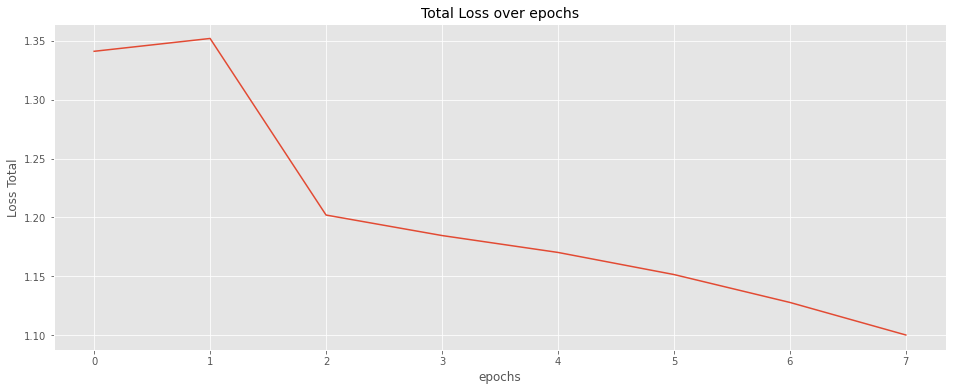

In [41]:
plt.subplots(figsize = (16,6))
plt.plot(history_train.history['total_loss'] )
plt.title("Total Loss over epochs", fontsize=14)
plt.ylabel('Loss Total')
plt.xlabel('epochs')
plt.show()

As the model trains, the loss is falling and a set of top-k retrieval metrics is updated. 
- These tell us whether the true positive is in the top-k retrieved items from the entire candidate set. 
- For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

In [42]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

11/11 [==============================] - 2s 110ms/step - root_mean_squared_error: 1.0711 - factorized_top_k/top_1_categorical_accuracy: 0.0723 - factorized_top_k/top_5_categorical_accuracy: 0.1022 - factorized_top_k/top_10_categorical_accuracy: 0.1153 - factorized_top_k/top_50_categorical_accuracy: 0.1852 - factorized_top_k/top_100_categorical_accuracy: 0.2359 - loss: 1.1437 - regularization_loss: 0.0000e+00 - total_loss: 1.1437
Retrieval top-100 accuracy: 0.236.
Ranking RMSE: 1.071.


**We get a good RMSE but with poor prediction**

### Retrieval-specialized model
**Let's now try a model that focuses on retrieval only.**

In [34]:
model = MovielensModel(rating_weight=0.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [35]:
model.fit(cached_train, epochs=8)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/8
9/9 [==============================] - 6s 548ms/step - root_mean_squared_error: 3.7024 - factorized_top_k/top_1_categorical_accuracy: 2.8577e-04 - factorized_top_k/top_5_categorical_accuracy: 5.2643e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0010 - factorized_top_k/top_50_categorical_accuracy: 0.0225 - factorized_top_k/top_100_categorical_accuracy: 0.0576 - loss: 60356.6773 - regularization_loss: 0.0000e+00 - total_loss: 60356.6773
Epoch 2/8
9/9 [==============================] - 5s 547ms/step - root_mean_squared_error: 3.7024 - factorized_top_k/top_1_categorical_accuracy: 2.8577e-04 - factorized_top_k/top_5_categorical_accuracy: 5.2643e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0010 - factorized_top_k/top_50_categorical_accuracy: 0.0225 - factorized_top_k/top_100_categorical_accuracy: 0.0576 - loss: 60356.6773 - regularization_loss: 0.0000e+00 - total_loss: 60356.6773
Epoch 3/8
9/9 [==============================] - 5s 553ms/step - root_mean_squared_err

11/11 [==============================] - 2s 134ms/step - root_mean_squared_error: 3.6912 - factorized_top_k/top_1_categorical_accuracy: 3.1586e-04 - factorized_top_k/top_5_categorical_accuracy: 6.7683e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0013 - factorized_top_k/top_50_categorical_accuracy: 0.0229 - factorized_top_k/top_100_categorical_accuracy: 0.0578 - loss: 15094.9468 - regularization_loss: 0.0000e+00 - total_loss: 15094.9468
Retrieval top-100 accuracy: 0.058.
Ranking RMSE: 3.691.


**We get a less impressive RMSE coupled with a poor prediction too**

### Joint model: Baseline

**Let's now train a model that assigns positive weights to both tasks.**

In [36]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [37]:
model.fit(cached_train, epochs=8)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/8
9/9 [==============================] - 6s 560ms/step - root_mean_squared_error: 2.7752 - factorized_top_k/top_1_categorical_accuracy: 0.0899 - factorized_top_k/top_5_categorical_accuracy: 0.1295 - factorized_top_k/top_10_categorical_accuracy: 0.1496 - factorized_top_k/top_50_categorical_accuracy: 0.2214 - factorized_top_k/top_100_categorical_accuracy: 0.2597 - loss: 60363.1939 - regularization_loss: 0.0000e+00 - total_loss: 60363.1939
Epoch 2/8
9/9 [==============================] - 5s 606ms/step - root_mean_squared_error: 1.2133 - factorized_top_k/top_1_categorical_accuracy: 0.0827 - factorized_top_k/top_5_categorical_accuracy: 0.1292 - factorized_top_k/top_10_categorical_accuracy: 0.1498 - factorized_top_k/top_50_categorical_accuracy: 0.2343 - factorized_top_k/top_100_categorical_accuracy: 0.2830 - loss: 60358.1180 - regularization_loss: 0.0000e+00 - total_loss: 60358.1180
Epoch 3/8
9/9 [==============================] - 5s 557ms/step - root_mean_squared_error: 1.1141 - fac

11/11 [==============================] - 2s 131ms/step - root_mean_squared_error: 1.0865 - factorized_top_k/top_1_categorical_accuracy: 0.0888 - factorized_top_k/top_5_categorical_accuracy: 0.1375 - factorized_top_k/top_10_categorical_accuracy: 0.1474 - factorized_top_k/top_50_categorical_accuracy: 0.2260 - factorized_top_k/top_100_categorical_accuracy: 0.2854 - loss: 15096.1242 - regularization_loss: 0.0000e+00 - total_loss: 15096.1242
Retrieval top-100 accuracy: 0.285.
Ranking RMSE: 1.087.


### Summary of the Baseline Joint Model 

| Models | Retrieval top-10 accuracy | Retrieval top-100 accuracy | Ranking RMSE |
| --- | --- | --- | --- |
| Model: Rating-specialized model | 0.1153 | 0.236 | 1.071 |
| Model: Retrieval-specialized model | 0.0013 | 0.058 | 3.691 |
| Model: Joint model: Baseline | 0.1474 | 0.285 | 1.087 |

**The joint model seems to provide an overall better prediction than the other independent models**

**What can we improve upon the joint model?**

- Adding more features
- Optimize Embedding
- embedding_dimension
- epochs= 8 to 16
- Learning rate

#### Case 2: Tuned Joint Model

In [43]:
# Re-Loading the datasets
# Ratings data.
ratings = pd.read_csv('ratings.csv', encoding='ISO-8859-1')
# Features of all the available movies.
movies = pd.read_csv('df_movies.csv', encoding='ISO-8859-1')

In [44]:
# Making sure the types are consistend with tf
ratings['movie_id'] = ratings['movie_id'].astype('str')
movies['movie_id'] = movies['movie_id'].astype('str')
ratings['user_id'] = ratings['user_id'].astype('str')
ratings['user_zip_code'] = ratings['user_zip_code'].astype('str')
ratings['bucketized_user_age'] = ratings['bucketized_user_age'].astype('int64')
ratings['timestamp'] = ratings['timestamp'].astype('int64')
ratings['release_date'] = ratings['release_date'].astype('int64')
ratings['user_rating'] = ratings['user_rating'].astype('int64')


In [45]:
#let's have a general view:
ratings_missing = pd.concat([ratings.nunique(), ratings.dtypes, ratings.isnull().sum(), 100*ratings.isnull().mean()], axis=1)
ratings_missing.columns = [['count', 'data_type', 'missing_count', 'missing%']]
ratings_missing

,count,data_type,missing_count,missing%
bucketized_user_age,7,int64,0,0.0
movie_genres,179,object,0,0.0
movie_id,1117,object,0,0.0
movie_title,1099,object,0,0.0
timestamp,40530,int64,0,0.0
user_gender,2,bool,0,0.0
user_id,925,object,0,0.0
user_occupation_label,17,int64,0,0.0
user_occupation_text,21,object,0,0.0
user_rating,5,int64,0,0.0


In [46]:
#let's have a general view:
movies_missing = pd.concat([movies.nunique(), movies.dtypes, movies.isnull().sum(), 100*movies.isnull().mean()], axis=1)
movies_missing.columns = [['count', 'data_type', 'missing_count', 'missing%']]
movies_missing

,count,data_type,missing_count,missing%
Unnamed: 0,1682,int64,0,0.0
movie_genres,216,object,0,0.0
movie_id,1682,object,0,0.0
movie_title,1664,object,0,0.0


### Implementing a Retrieval Model:

In [47]:
#let's wrap the **pandas dataframe** into **tf.data.Dataset** object using **tf.data.Dataset.from_tensor_slices** using: tf.data.Dataset.from_tensor_slices
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings))
movies = tf.data.Dataset.from_tensor_slices(dict(movies))

In [48]:
#The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:
#View the data from the ratings dataset:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'bucketized_user_age': 45,
 'director': b'Milos Forman',
 'movie_genres': b'[7]',
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest",
 'release_date': 185500800,
 'star': b'Jack Nicholson',
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4,
 'user_zip_code': b'53211'}


In [49]:
#The ratings dataset returns a dictionary of movie id, user id, the assigned rating, timestamp, movie information, and user information:
#View the data from the movies dataset:
for x in movies.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'Unnamed: 0': 0,
 'movie_genres': b'[4]',
 'movie_id': b"b'1681'",
 'movie_title': b"b'You So Crazy (1994)'"}


In [50]:
# Selecting the basic features.
ratings = ratings.map(lambda x: {
                                "movie_title": x["movie_title"],
                                "user_id": x["user_id"],
                                "user_rating": x["user_rating"],
                                "timestamp": x["timestamp"],
                                "bucketized_user_age": x['bucketized_user_age'],
                                "gender": tf.dtypes.cast(x["user_gender"], tf.int64),
                                "director": x["director"],
                                "star": x["star"],
                               })
movies = movies.map(lambda x: {
                                "movie_title": x["movie_title"], 
                                
})

In [51]:
# let's use a random split, putting 75% of the ratings in the train set, and 25% in the test set:
# Assign a seed=42 for consistency of results and reproducibility:
seed = 42
l = len(ratings)

tf.random.set_seed(seed)
shuffled = ratings.shuffle(l, seed=seed, reshuffle_each_iteration=False)

#Save 80% of the data for training and 20% for testing:
train_ = int(0.75 * l)
test_ = int(0.25 * l)

train = shuffled.take(train_)
test = shuffled.skip(train_).take(test_)

In [52]:
# Randomly shuffling data and splitting between train and test.
tf.random.set_seed(42)
shuffled = ratings.shuffle(1_000_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(800_000)
test = shuffled.skip(800_000).take(200_000)

movie_titles = movies.batch(10_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

In [53]:
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_movie_titles[:10]

array([b'b"\'Til There Was You (1997)"',
       b'b"Amityville 1992: It\'s About Time (1992)"',
       b'b"Antonia\'s Line (1995)"', b'b"April Fool\'s Day (1986)"',
       b'b"Blood For Dracula (Andy Warhol\'s Dracula) (1974)"',
       b'b"Boy\'s Life 2 (1997)"', b'b"Bram Stoker\'s Dracula (1992)"',
       b'b"Breakfast at Tiffany\'s (1961)"',
       b'b"Brother\'s Kiss, A (1997)"',
       b'b"C\'est arriv\\xc3\\xa9 pr\\xc3\\xa8s de chez vous (1992)"'],
      dtype=object)

In [54]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

In [55]:
user_age = ratings.batch(1_000_000).map(lambda x: x["bucketized_user_age"])
unique_user_age = np.unique(np.concatenate(list(user_age)))

In [56]:
max_age = unique_user_age.max()
min_age = unique_user_age.min()

age_buckets = np.linspace(
                         min_age, 
                         max_age, 
                         num=7,
                         )

In [57]:
age_buckets = age_buckets.astype('int64')
age_buckets

array([ 1, 10, 19, 28, 37, 46, 56], dtype=int64)

In [58]:
user_gender = ratings.batch(1_000_000).map(lambda x: x['gender'] )
unique_user_gender = np.unique(np.concatenate(list(user_gender)))
unique_user_gender

array([0, 1], dtype=int64)

####  A Multi-Task Model

There are two critical parts to multi-task recommenders:

- They optimize for two or more objectives, and so have two or more losses.
- They share variables between the tasks, allowing for transfer learning.

Now, let's define our models as before, but instead of having a single task, we will have two tasks: one that predicts ratings, and one that predicts movie watches

In [59]:
embedding_dimension = 32

user_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add 1 to account for the unknown token.
  tf.keras.layers.Embedding(len(unique_user_ids) + 2, embedding_dimension)
])

movie_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 2, embedding_dimension)
])

**However, now we will have two tasks. The first is the rating task:**

In [60]:
tfrs.tasks.Ranking(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

**Its goal is to predict the ratings as accurately as possible.**

**The second is the retrieval task:**

In [61]:
tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128)
    )
)

As before, this task's goal is to predict which movies the user will or will not watch.

Those folowwing classes were re-configured to accomodate the new embedded design due to new features, having deeper neural networks and adding regularization to help overfitting:

- class UserModel
- class QueryModel
- class MovieModel
- class MovieModel
- class CandidateModel
- class MovielensModel

In [62]:
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        embedding_dimension = 32

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension),

        ])
        self.timestamp_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
            tf.keras.layers.Embedding(len(timestamp_buckets) + 1, embedding_dimension),

        ])
        self.normalized_timestamp = tf.keras.layers.experimental.preprocessing.Normalization()

        self.normalized_timestamp.adapt(timestamps)

      #  self.age_embedding = tf.keras.Sequential([
       #     tf.keras.layers.experimental.preprocessing.Discretization(age_buckets.tolist()),
        #    tf.keras.layers.Embedding(len(age_buckets) + 1, embedding_dimension//2),
      #  ])

        #self.normalized_age = tf.keras.layers.experimental.preprocessing.Normalization()

       # self.normalized_age.adapt(unique_user_age)

        self.gender_embedding = tf.keras.layers.experimental.preprocessing.CategoryEncoding(
            max_tokens=len(unique_user_gender) + 1)


    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            self.normalized_timestamp(inputs["timestamp"]),
            #self.age_embedding(inputs["user_age"]),
            #self.normalized_age(inputs["user_age"]),
            self.gender_embedding(inputs["gender"])
        ], axis=1)

In [63]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes):
        """Model for encoding user queries.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
            self.dense_layers.add(tf.keras.layers.Dropout(0.2))
    
    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [64]:
class MovieModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        max_tokens = 10_000
        embedding_dimension = 32

        self.title_embedding = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=unique_movie_titles,mask_token=None),
          tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension),

        ])

        self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=max_tokens)

        self.title_text_embedding = tf.keras.Sequential([
          self.title_vectorizer,
          tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
          tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.title_vectorizer.adapt(movies.map(lambda x: x['movie_title']))

    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles),
        ], axis=1)

In [65]:
class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""

    def __init__(self, layer_sizes):
        """Model for encoding movies.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        self.embedding_model = MovieModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
            self.dense_layers.add(tf.keras.layers.Dropout(0.2))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
    def call(self, inputs):
            feature_embedding = self.embedding_model(inputs)
            return self.dense_layers(feature_embedding)

In [66]:
class MovielensModel(tfrs.models.Model):
    def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
        # We take the loss weights in the constructor: this allows us to instantiate
        # several model objects with different loss weights.

        super().__init__()

        layer_sizes = [64, 32, 32, 32, 32]

        # User and movie models.
        self.movie_model: tf.keras.layers.Layer = CandidateModel(layer_sizes)

        self.user_model: tf.keras.layers.Layer = QueryModel(layer_sizes)

        # A small model to take in user and movie embeddings and predict ratings.
        # We can make this as complicated as we want as long as we output a scalar
        # as our prediction.
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        # The tasks.
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(lambda x: x['movie_title']).map(self.movie_model)
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model({
            "user_id": features["user_id"],
            "timestamp": features["timestamp"],
           # "user_age": features["user_age"],
            "gender": features["gender"],
        })
        # And pick out the movie features and pass them into the movie model.
        movie_embeddings = self.movie_model(features["movie_title"])

        return (
            user_embeddings,
            movie_embeddings,
            # We apply the multi-layered rating model to a concatentation of
            # user and movie embeddings.
            self.rating_model(
                tf.concat([user_embeddings, movie_embeddings], axis=1)
            ),
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        user_embeddings, movie_embeddings, rating_predictions = self(features)


        # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=features["user_rating"],
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

        # And combine them using the loss weights.
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

### Joint model

Let's now train a model that assigns positive weights to both tasks.

In [71]:
user_model

In [72]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [73]:
cached_train = train.shuffle(1_000_000).batch(8192).cache()
cached_test = test.batch(2048).cache()

In [74]:
Final = model.fit(cached_train, validation_data = cached_test, epochs=16)

Epoch 1/16
11/11 [==============================] - 11s 776ms/step - root_mean_squared_error: 3.1389 - factorized_top_k/top_1_categorical_accuracy: 0.3231 - factorized_top_k/top_5_categorical_accuracy: 0.3439 - factorized_top_k/top_10_categorical_accuracy: 0.3530 - factorized_top_k/top_50_categorical_accuracy: 0.3783 - factorized_top_k/top_100_categorical_accuracy: 0.3943 - loss: 71582.0553 - regularization_loss: 0.0000e+00 - total_loss: 71582.0553
Epoch 2/16
11/11 [==============================] - 9s 768ms/step - root_mean_squared_error: 2.7269 - factorized_top_k/top_1_categorical_accuracy: 0.7092 - factorized_top_k/top_5_categorical_accuracy: 0.7110 - factorized_top_k/top_10_categorical_accuracy: 0.7113 - factorized_top_k/top_50_categorical_accuracy: 0.7124 - factorized_top_k/top_100_categorical_accuracy: 0.7137 - loss: 71407.3639 - regularization_loss: 0.0000e+00 - total_loss: 71407.3639
Epoch 3/16
11/11 [==============================] - 8s 757ms/step - root_mean_squared_error: 1.

### Summary of all models' metrics

| Models | Retrieval top-10 accuracy | Retrieval top-100 accuracy | Ranking RMSE |
| --- | --- | --- | --- |
| Model: Rating-specialized model | 0.1153 | 0.236 | 1.071 |
| Model: Retrieval-specialized model | 0.0013 | 0.058 | 3.691 |
| Model: Joint model: Baseline | 0.1474 | 0.285 | 1.087 |
| Model: Tuned Joint model (Best Model for teh Recommendation) | 0.9544 | 0.96 | 1.11 |

In [83]:
model.user_model
model.movie_model
tf.constant(["0"])

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'0'], dtype=object)>

In [86]:
type(movie_model)

tensorflow.python.keras.engine.sequential.Sequential

In [84]:
# Recommend the 5 best movies for user 42:

# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

# recommends movies out of the entire movies dataset.
index.index(movies.batch(100).map(model.movie_model), movies)

# Get recommendations.
_, titles = index(tf.constant(["0"]))
print(f"Recommendations for user 42: {titles[0, :5]}")

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


ValueError: Attempt to convert a value (<MapDataset shapes: (None, 32), types: tf.float32>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>) to a Tensor.